In [2]:
import pandas as pd 

X_train = pd.read_csv("../../datasets/merged/X_train_imputed_scaled.csv", index_col=0)
X_test = pd.read_csv("../../datasets/merged/X_test_imputed_scaled.csv",  index_col=0)
y_train = pd.read_csv("../../datasets/merged/y_train.csv", index_col=0)["label"]
y_test = pd.read_csv("../../datasets/merged/y_test.csv",  index_col=0)["label"]
groups = pd.read_csv("../../datasets/merged/groups.csv", index_col=0)["star_key"]

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plot_metrics_vs_threshold(y_true, y_proba, title="Metrics vs Threshold"):
    thresholds = np.linspace(0.0, 1.0, 501)
    accs, precs, recs, f1s = [], [], [], []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred, zero_division=0))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(8,5))
    plt.plot(thresholds, accs, label="Accuracy")
    plt.plot(thresholds, precs, label="Precision")
    plt.plot(thresholds, recs, label="Recall")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [4]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401 (pre-1.0)
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

hgb = HistGradientBoostingClassifier(
    loss="log_loss",        # probabilistic
    random_state=42
)

param_grid = {
    "learning_rate":   [0.01, 0.05, 0.1],
    "max_depth":       [None, 6, 10],
    "max_leaf_nodes":  [31, 63, 127],   # ignored if max_depth set
    "min_samples_leaf":[20, 50, 100],
    "l2_regularization":[0.0, 1e-3, 1e-2],
    "max_bins":        [255],           # increase if you have RAM/time
    "early_stopping":  [True],          # uses a val split inside fit
}

scoring = {
    "f1": make_scorer(f1_score, pos_label= 1),
    "precision": make_scorer(precision_score, pos_label= 1),
    "recall": make_scorer(recall_score, pos_label=1),
    "precisionF" : make_scorer(precision_score, pos_label=0),
}

kf = GroupKFold(n_splits=5)

grid_hgb = RandomizedSearchCV(
    hgb,
    param_distributions=param_grid,
    scoring=scoring,
    cv=kf,
    n_jobs=-1,
    refit="f1",
    verbose=1,
)
grid_hgb.fit(X_train, y_train, groups=groups)

best_hgb = grid_hgb.best_estimator_
print("Best F1 (HGB):", grid_hgb.best_score_)
print("Best params (HGB):", grid_hgb.best_params_)


/Users/janma/miniconda3/lib/python3.12/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best F1 (HGB): 0.8599470181452098
Best params (HGB): {'min_samples_leaf': 100, 'max_leaf_nodes': 63, 'max_depth': 10, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 0.0, 'early_stopping': True}


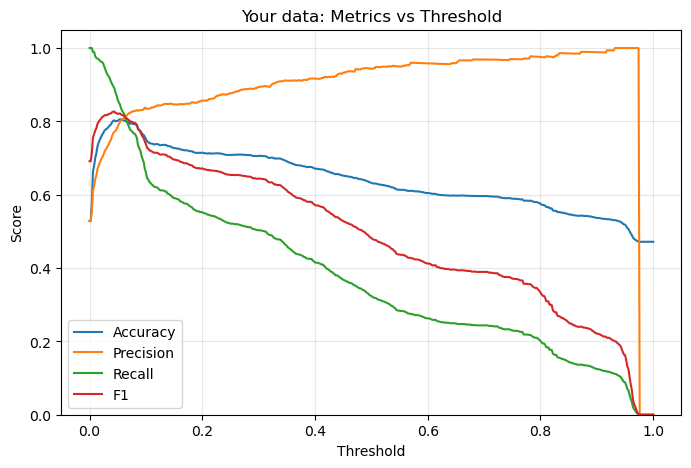

In [5]:
y_proba = best_hgb.predict_proba(X_test)[:, 1]

plot_metrics_vs_threshold(y_test, y_proba, title="Your data: Metrics vs Threshold")

In [6]:
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (y_proba >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 ≥ 0.80)")
y_pred_thr = (y_proba >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.020  (F1 ≥ 0.80)
Precision/Recall/F1 @ thr: 0.6943298969072165 0.9628305932809149 0.8068283917340521
[[ 656  593]
 [  52 1347]]


In [7]:
from pathlib import Path
import joblib

ARTS = Path("../../saved-models/merged")
ARTS.mkdir(parents=True, exist_ok=True)

In [8]:
bundle = {
    "model": best_hgb,            
    "threshold": thr_star,              
}

joblib.dump(bundle, ARTS / "merged_hgb.pkl")
print("Saved →", ARTS / "merged_hgb.pkl")

Saved → ../../saved-models/merged/merged_hgb.pkl


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score
)

def plot_cm_and_pr(y_true, y_proba, threshold=0.5, title="Model"):
    """
    y_true  : array-like (n,), binary labels {0,1}
    y_proba : array-like (n,), predicted probabilities for the positive class
    threshold : float in [0,1] to convert probabilities to hard labels
    title   : str, used in plot titles/legend
    """
    y_true  = np.asarray(y_true).astype(int)
    y_proba = np.asarray(y_proba).astype(float)
    y_pred  = (y_proba >= threshold).astype(int)

    # --- Confusion matrices ---
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(ax=ax[0], colorbar=False)
    ax[0].set_title(f"{title} — Confusion Matrix (θ={threshold:.2f})")
    ax[0].grid(False)

    cm_norm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")
    ConfusionMatrixDisplay(cm_norm, display_labels=[0, 1]).plot(ax=ax[1], colorbar=False)
    ax[1].set_title(f"{title} — Confusion Matrix (Normalized)")
    ax[1].grid(False)

    plt.tight_layout()
    plt.show()

    # --- Precision–Recall curve & PR-AUC ---
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    baseline = y_true.mean()  # positive rate

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, lw=2, label=f"{title} (AP={ap:.3f})")
    plt.hlines(baseline, 0, 1, colors="gray", linestyles="--",
               label=f"Baseline (pos rate={baseline:.3f})", alpha=0.7)
    plt.xlim(0, 1); plt.ylim(0, 1.01)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} — Precision–Recall Curve")
    plt.grid(True, linestyle=":")
    plt.legend()
    plt.show()

    print(f"PR-AUC (Average Precision): {ap:.4f}")


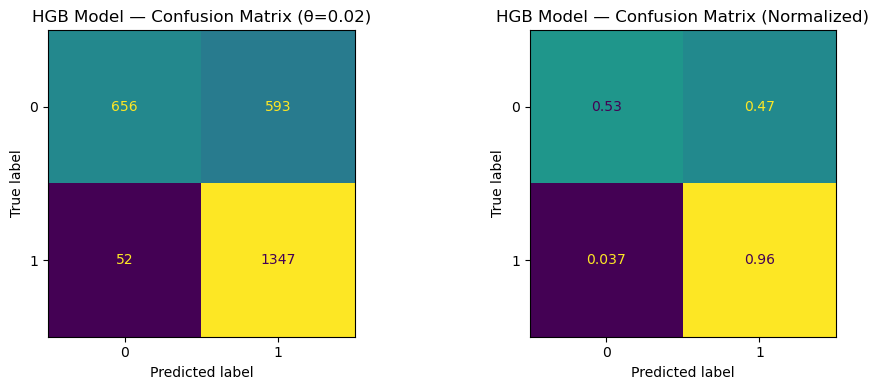

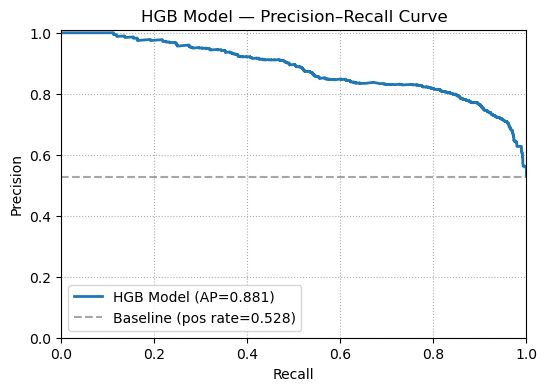

PR-AUC (Average Precision): 0.8808


In [13]:
plot_cm_and_pr(y_test, y_proba, thr_star, title="HGB Model")

Our model correctly identifies 1347 planets and 656 non-planets. It identified 52 planets as non-planets and 593 non-planets as planets. This is a common trade-off - this proportion could be inversed by tuning the hyperparameters based on the researcher's needs - whether he prefers to identify more objects as planets but be more certain that all actual planets are identified as such, or identify less planets overall but also receive less false positives. This particular implementation is tailored to that first need.  
Precision-Recall curve shows that the model maintains high precision averaged over all recall levels 